# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [4]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 展示競争の進入コース
    fv_list.append("exhibition_cource_{0}".format(i))
    
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

In [5]:
print(fv_label_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

In [6]:
print(fv_label_odds_df)

       class_1  aveST_frame1  placeRate_frame1  win_rate_national_1  \
17422      0.0          18.0             853.0                 7.14   
17423      2.0          16.0             545.0                 5.51   
17424      1.0          13.0             880.0                 6.29   
17425      2.0          18.0             273.0                 3.58   
17426      0.0          15.0             923.0                 6.50   
17427      2.0          14.0             417.0                 4.46   
17428      1.0          15.0             682.0                 6.30   
17429      0.0          16.0             840.0                 5.91   
17430      0.0          13.0             885.0                 7.13   
17431      0.0          14.0             848.0                 7.80   
17362      0.0          15.0             739.0                 6.86   
17363      2.0          19.0             538.0                 5.05   
17364      2.0          35.0             250.0                 3.24   
17365 

1号艇についてtrainデータを使った正解率は0.7038771305487919,
           testデータを使った正解率は0.6601135867190913
切片は[-0.05079034]
2号艇についてtrainデータを使った正解率は0.680277205469189,
           testデータを使った正解率は0.6601135867190913
切片は[0.00996738]
3号艇についてtrainデータを使った正解率は0.6662296310170444,
           testデータを使った正解率は0.6373962429008301
切片は[0.05008653]
4号艇についてtrainデータを使った正解率は0.6767184866079791,
           testデータを使った正解率は0.6627348186981215
切片は[0.04474136]
5号艇についてtrainデータを使った正解率は0.708185053380783,
           testデータを使った正解率は0.6788990825688074
切片は[-0.05934647]
6号艇についてtrainデータを使った正解率は0.7640007492039708,
           testデータを使った正解率は0.7501092179991262
切片は[-0.02809941]


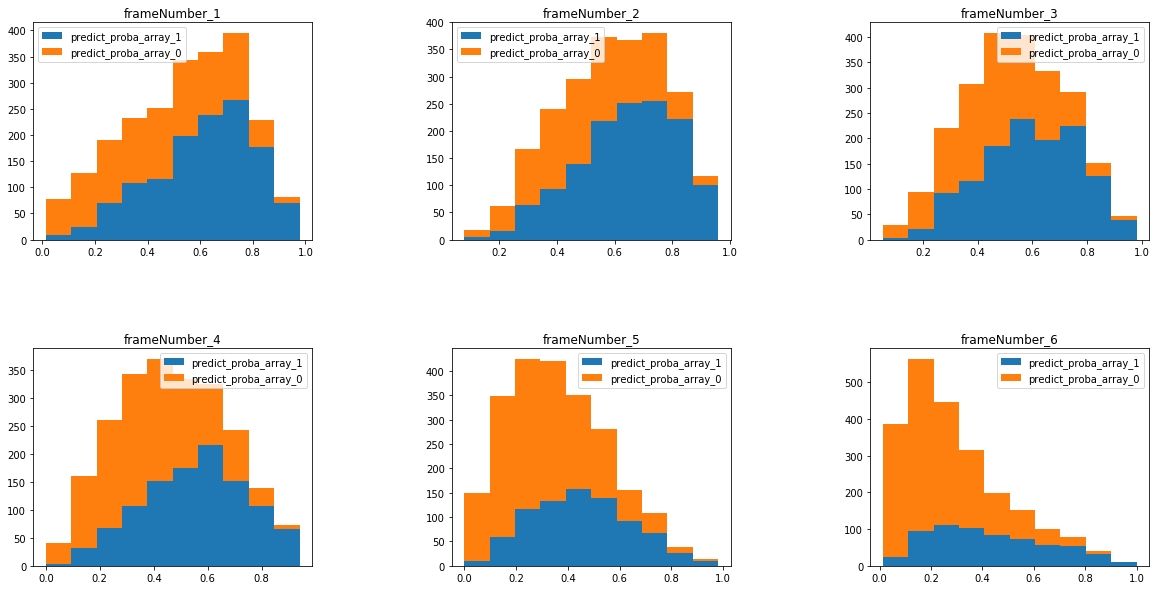

In [7]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [8]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.518202    0.526932    0.204870    0.575020    0.854487    0.126391   
1       0.574593    0.863755    0.415571    0.429736    0.179141    0.203560   
2       0.184938    0.678834    0.540185    0.289633    0.850131    0.158069   
3       0.300651    0.620876    0.756694    0.552710    0.251964    0.163751   
4       0.485633    0.412858    0.599853    0.481063    0.358430    0.439225   
5       0.680369    0.483817    0.523761    0.625258    0.192663    0.192692   
6       0.805350    0.683296    0.645658    0.183594    0.308933    0.201098   
7       0.429623    0.468907    0.709327    0.323263    0.365769    0.431739   
8       0.889835    0.632425    0.424343    0.693044    0.054669    0.320258   
9       0.679733    0.520274    0.659864    0.298437    0.343477    0.218205   
10      0.767273    0.687158    0.578107    0.194633    0.364613    0.309727   
11      0.592130    0.859575    0.507584

In [9]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.710019267822736, 回収率は0.9550096339113681
確率0.7以上で1に単勝betした場合、的中率は0.7285276073619632, 回収率は0.9455521472392638
確率0.8以上で1に単勝betした場合、的中率は0.8044280442804428, 回収率は0.9675276752767528


In [10]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-8170, 回収率は0.9301709401709402
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-4970, 回収率は0.9366071428571429
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は430, 回収率は1.0103864734299517
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は1380, 回収率は1.1007299270072992
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-7090, 回収率は0.9073202614379084
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-3680, 回収率は0.9289575289575289
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-1090, 回収率は0.9605072463768116
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-130, 回収率は0.9848837209302326
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-2110, 回収率は0.95491452991453
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-1180, 回収率は0.9626582278481013
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-10, 回収率は0.999421965317919
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は730, 回収率は1.1216666666666666


In [11]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-210890, 回収率は0.7929202670856245
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-131960, 回収率は0.7512066365007541
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-18320, 回収率は0.8963800904977376
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-144210, 回収率は0.7700733418367347
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-92400, 回収率は0.7210144927536232
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-3280, 回収率は0.9700729927007299
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-45380, 回収率は0.8204905063291139
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-36670, 回収率は0.735043352601156
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は190, 回収率は1.0039583333333333


In [12]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-121330, 回収率は0.9194997346072187
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-58620, 回収率は0.9451123595505618
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-66710, 回収率は0.9029813845258872
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-35720, 回収率は0.904389721627409
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は13090, 回収率は1.096819526627219
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-135370, 回収率は0.8770704685797313
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-60240, 回収率は0.9223711340206185
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-65760, 回収率は0.8708562450903378
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-30540, 回収率は0.884841628959276
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-840, 回収率は0.9904977375565611
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-94740, 回収率は0.8584279736999402
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-61040, 回収率は0.8695726495726496
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-61690, 回収率は0.8032844387755103
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-31400, 回収率は0.8103864734299517
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-4390, 回収率は0.9198905109489051
p1が0.8以上かつ、p2-6が0.4以上で3連単betする

In [13]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-440, 回収率は0.9988781234064253
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-11160, 回収率は0.9642307692307692
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-17180, 回収率は0.8285429141716567
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-10400, 回収率は0.9565217391304348
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-1620, 回収率は0.9923440453686201
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-15150, 回収率は0.7860169491525424
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-17770, 回収率は0.8055798687089716
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-3640, 回収率は0.9610278372591007
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-9050, 回収率は0.7223926380368099


In [14]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-145730, 回収率は0.884798418972332
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-22290, 回収率は0.9684367034834325
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は23520, 回収率は1.075968992248062
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は3760, 回収率は1.0361538461538462
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は380, 回収率は1.015079365079365
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は620, 回収率は1.2384615384615385
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-89160, 回収率は0.9008451957295374
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-15690, 回収率は0.9687823318742539
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は19690, 回収率は1.090904893813481
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は15170, 回収率は1.1990813648293963
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は1870, 回収率は1.1126506024096385
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は1040, 回収率は2.04
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-63500, 回収率は0.8814413741598207
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-22420, 回収率は0.9229023383768913
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-3860, 回収率は0.9683087027914614
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は9200, 回収率は1.197424892703

In [15]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-24010, 回収率は0.9578328064629434
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は8910, 回収率は1.0218382352941175
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は37270, 回収率は1.144233746130031
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は30340, 回収率は1.1990813648293963
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-8010, 回収率は0.970830298616169
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は11610, 回収率は1.059660842754368
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は15730, 回収率は1.1302152317880794
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は10800, 回収率は1.149171270718232
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は3740, 回収率は1.1126506024096385
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は8920, 回収率は1.1072115384615384
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は8990, 回収率は1.155
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は9750, 回収率は1.2785714285714285
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は9250, 回収率は1.4447115384615385
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-250, 回収率は0.9709302325581395
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は208

In [16]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は670, 回収率は1.0071888412017167
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-260, 回収率は0.9955172413793103
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-6360, 回収率は0.7338912133891213
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-13910, 回収率は0.7172764227642277
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-6880, 回収率は0.7602787456445993
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3600, 回収率は0.6697247706422018
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-11220, 回収率は0.6321311475409837
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2280, 回収率は0.8726256983240224
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3340, 回収率は0.49393939393939396
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-6220, 回収率は0.5426470588235294
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-3370, 回収率は0.5988095238095238
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1170, 回収率は0.6657142857142857


In [17]:
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-24010, 回収率は0.9578328064629434
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は8910, 回収率は1.0218382352941175
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は37270, 回収率は1.144233746130031
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は30340, 回収率は1.1990813648293963
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-8010, 回収率は0.970830298616169
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は11610, 回収率は1.059660842754368
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は15730, 回収率は1.1302152317880794
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は10800, 回収率は1.149171270718232
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は3740, 回収率は1.1126506024096385
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は8920, 回収率は1.1072115384615384
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は8990, 回収率は1.155
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は9750, 回収率は1.2785714285714285
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は9250, 回収率は1.4447115384615385
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-250, 回収率は0.9709302325581395
p1が0.6以上かつ、p2が0.8以上かつp3が0.8で3連単betすると収益は208

In [18]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-2270, 回収率は0.9678014184397163
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-380, 回収率は0.9903553299492386
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1930, 回収率は0.857037037037037
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は3470, 回収率は1.0896640826873385
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-170, 回収率は0.9918269230769231
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-2720, 回収率は0.5878787878787879
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は6530, 回収率は1.270954356846473
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は4100, 回収率は1.3106060606060606
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1860, 回収率は0.5772727272727273
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は6810, 回収率は1.709375
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は1570, 回収率は1.301923076923077
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-760, 回収率は0.5529411764705883


In [19]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-15140, 回収率は0.6910204081632653
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-5110, 回収率は0.7843881856540085
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-3110, 回収率は0.650561797752809
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-6050, 回収率は0.7380952380952381
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1250, 回収率は0.8711340206185567
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-290, 回収率は0.8964285714285715
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-2750, 回収率は0.793233082706767
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-270, 回収率は0.9526315789473684
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-780, 回収率は0.48
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-1210, 回収率は0.758
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は1590, 回収率は1.7227272727272727
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-300, 回収率は0.0


In [20]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-360, 回収率は0.996137339055794
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は5560, 回収率は1.0958620689655172
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は3720, 回収率は1.1556485355648536
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は2990, 回収率は1.0607723577235773
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は3590, 回収率は1.1250871080139373
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は2630, 回収率は1.2412844036697248
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-900, 回収率は0.9704918032786886
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は550, 回収率は1.0307262569832403
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は1000, 回収率は1.1515151515151516
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は2570, 回収率は1.1889705882352941
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は1430, 回収率は1.1702380952380953
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は490, 回収率は1.14


In [21]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1 > 0.3、p2 > 0.6, p3 > 0.2で3連単2-1-i にbetすると収益は12370, 回収率は1.0439587775408672
p1 > 0.3、p2 > 0.6, p3 > 0.3で3連単2-1-i にbetすると収益は20790, 回収率は1.0958948339483394
p1 > 0.3、p2 > 0.6, p3 > 0.4で3連単2-1-i にbetすると収益は15780, 回収率は1.1004455760662
p1 > 0.3、p2 > 0.6, p3 > 0.5で3連単2-1-i にbetすると収益は37870, 回収率は1.37681592039801
p1 > 0.3、p2 > 0.6, p3 > 0.6で3連単2-1-i にbetすると収益は29130, 回収率は1.5092657342657343
p1 > 0.3、p2 > 0.7, p3 > 0.2で3連単2-1-i にbetすると収益は18230, 回収率は1.1081899109792286
p1 > 0.3、p2 > 0.7, p3 > 0.3で3連単2-1-i にbetすると収益は22540, 回収率は1.1781818181818182
p1 > 0.3、p2 > 0.7, p3 > 0.4で3連単2-1-i にbetすると収益は5880, 回収率は1.0644030668127054
p1 > 0.3、p2 > 0.7, p3 > 0.5で3連単2-1-i にbetすると収益は15170, 回収率は1.2620034542314336
p1 > 0.3、p2 > 0.7, p3 > 0.6で3連単2-1-i にbetすると収益は630, 回収率は1.0191489361702128
p1 > 0.3、p2 > 0.8, p3 > 0.2で3連単2-1-i にbetすると収益は-10360, 回収率は0.843267776096823
p1 > 0.3、p2 > 0.8, p3 > 0.3で3連単2-1-i にbetすると収益は-8450, 回収率は0.8296370967741935
p1 > 0.3、p2 > 0.8, p3 > 0.4で3連単2-1-i にbetすると収益は-9200, 回収率は0.7348703170028819
p1 > 0.

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す